In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl

In [88]:
df = pd.read_csv('train.csv')
dt = pd.read_csv('test.csv')
ids_test = dt['PassengerId']
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [89]:
def preprocess_data(data):
    dfp = data.copy()

    dfp['family'] = dfp['SibSp'] + dfp['Parch'] + 1
    dfp['alone'] = (dfp['family'] == 1).astype(int)

    dfp['title'] = dfp['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    dfp['title'] = dfp['title'].replace(['Lady', 'Countess','Capt', 'Col',
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'rare')
    dfp['title'] = dfp['title'].map({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'})
    dfp['title'] = dfp['title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "rare": 5}).fillna(0)

    dfp = dfp.drop(columns=['PassengerId','Name','Ticket', 'SibSp', 'Parch'])
    
    dfp['Sex'] = dfp['Sex'].map({'male': 1, 'female': 0})
    dfp['Embarked'] = dfp['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    dfp['floor'] = dfp['Cabin'].str[0]
    
    dfp['Cabin'] = dfp['Cabin'].str.extract(r'(\d+)')[0]
    
    #mediana por sexo e classe
    dfp['Age'] = dfp['Age'].fillna(
        dfp.groupby(['Sex', 'Pclass'])['Age'].transform('median')
    )
    
    #valor mais comum
    dfp['Embarked'] = dfp['Embarked'].fillna(
        dfp['Embarked'].mode()[0]
    )

    dfp['Fare'] = dfp['Fare'].fillna(dfp['Fare'].median())

    dfp['Age'] = (pd.cut(dfp['Age'], bins=[0, 12, 20, 40, 60, 120], labels=[0, 1, 2, 3, 4])).astype(int)
    dfp['Fare'] = (pd.qcut(dfp['Fare'], q=4, labels=[0, 1, 2, 3], duplicates='drop')).astype(int)
    
    dfp['floor'] = dfp['floor'].fillna('U')
    dfp['Cabin'] = dfp['Cabin'].fillna(0)
    
    dfp['floor'] = dfp['floor'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8, 'U': 0})
    
    dfp['Cabin'] = dfp['Cabin'].astype(int)
    
    return dfp

df = preprocess_data(df)
dt = preprocess_data(dt)

In [90]:
# # Verificar quantidade de NaN por coluna
# print("Valores NaN por coluna:")
# print(df.isnull().sum())
# print("\n% de NaN:")
# print((df.isnull().sum() / len(df) * 100).round(2))

In [91]:
x = df.drop(columns='Survived')
y = df['Survived']
print("Shape treino:", x.shape, y.shape)
print("Shape teste:", dt.shape)

Shape treino: (891, 10) (891,)
Shape teste: (418, 10)


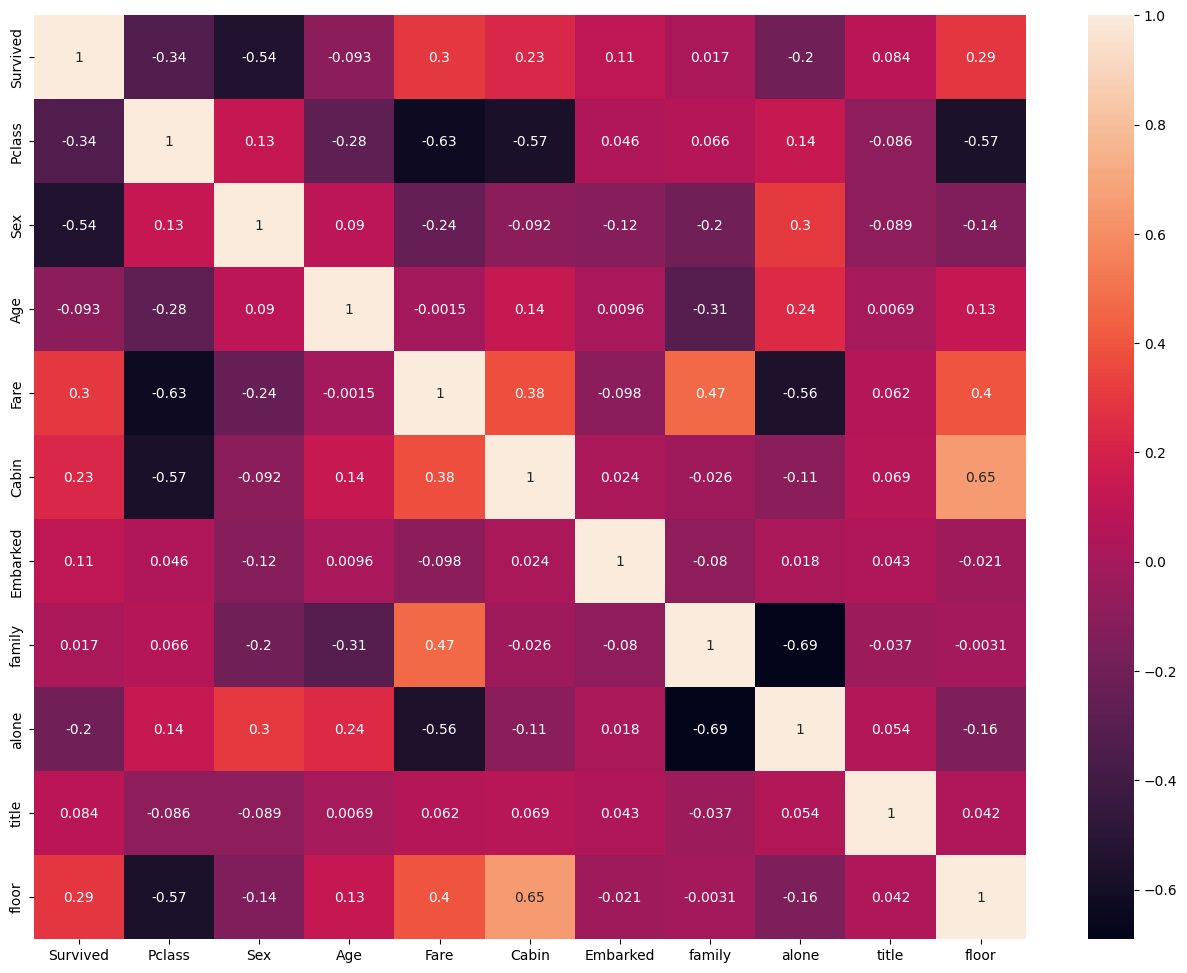

In [92]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

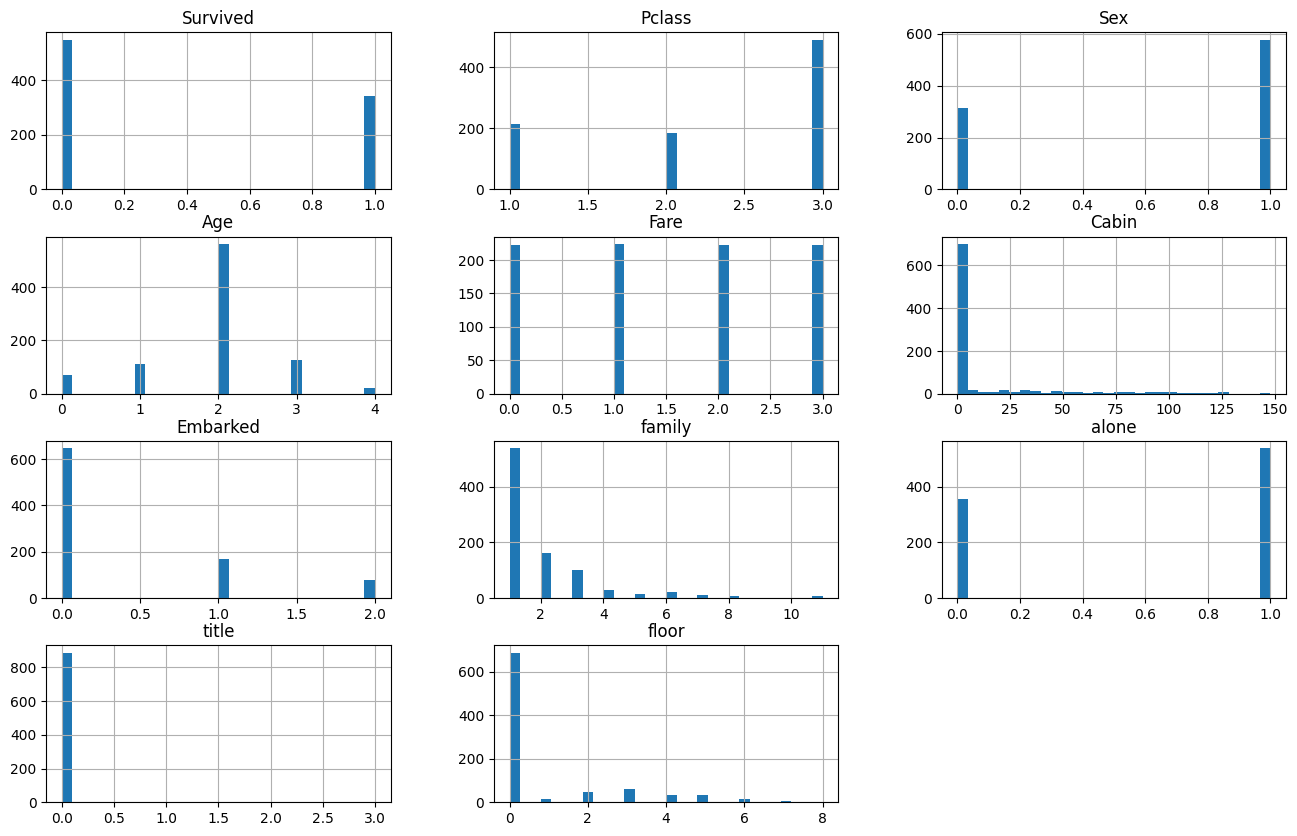

In [93]:
df.hist(bins=30, figsize=(16,10))
plt.show()

In [94]:
from sklearn.model_selection import train_test_split
#random state para mesmos resultados
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 140 to 684
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int64  
 2   Age       712 non-null    int32  
 3   Fare      712 non-null    int32  
 4   Cabin     712 non-null    int32  
 5   Embarked  712 non-null    float64
 6   family    712 non-null    int64  
 7   alone     712 non-null    int32  
 8   title     712 non-null    float64
 9   floor     712 non-null    int64  
dtypes: float64(2), int32(4), int64(4)
memory usage: 50.1 KB


In [95]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(objective ='binary:logistic', eval_metric = 'error', learning_rate = 0.1, max_depth = 4, n_estimators = 200)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [96]:
result = xgb_classifier.score(X_test, y_test)
print("Accuracy no TREINO: {}".format(result))

predictions = xgb_classifier.predict(dt)

Accuracy no TREINO: 0.8547486033519553


In [97]:
from sklearn.metrics import classification_report
y_predict_test = xgb_classifier.predict(X_test)
print(classification_report(y_test, y_predict_test))
# precision is the ratio of TP/(TP+FP)
# recall is the ratio of TP/(TP+FN)
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# where an F-beta score reaches its best value at 1 and worst score at 0.

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       110
           1       0.86      0.74      0.80        69

    accuracy                           0.85       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.86      0.85      0.85       179



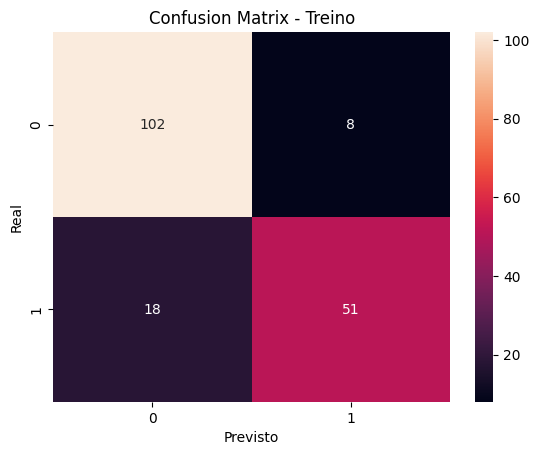

In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, fmt='d', annot=True)
plt.title('Confusion Matrix - Treino')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

In [99]:
#arquivo de submissão
submission = pd.DataFrame({
    'PassengerId': ids_test,
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)